In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
import numpy as np
import matplotlib.pylab as plt

import cv2

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

In [5]:
def apply_invert(frame):
    return cv2.bitwise_not(frame)

In [6]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    Transforms a colour image to a greyscale image by
    taking the mean of the RGB values, weighted
    by the matrix weights
    """
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

In [29]:
def _my_invert(x):
    return torch.inverse(x)
my_invert = TfmLighting(_my_invert)

In [66]:
def _my_flip_affine() -> TfmAffine:
    "Flip `x` horizontally."
    return [[-1, 0, 0.],
            [0,  1, 0],
            [0,  0, 1.]]
my_flip_affine = TfmAffine(_my_flip_affine)

In [ ]:
def _flip_lr(x):
    "Flip `x` horizontally."
    return x.flip(2)
flip_lr = TfmPixel(_flip_lr)

In [69]:
def _my_invert(x):
    return torch.inverse(x)
my_invert= TfmPixel(_my_invert)

In [98]:
def _my_brightness(x):
    "Apply `change` in brightness of image `x`."
    return x.add_(cv2.bitwise_not(x))
my_brightness = TfmLighting(_my_brightness)

In [97]:
def _my_inv(x, change:uniform):
    "Apply `change` in brightness of image `x`."
    return x.add_(np.invert(change).astype(np.int))
my_inv = TfmLighting(_my_inv)

In [99]:
def my_get_transforms(my_inv:bool=True, do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if my_inv:  res.append(my_inv())
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_affine(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

In [100]:
def my_get_transforms(my_inv:float=0.2, max_lighting:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, 
                      xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if max_lighting:
        res.append(my_brightness(p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

In [101]:
tfms = my_get_transforms(my_inv=0.4, max_lighting=0.4, p_lighting=1., p_affine=1.)

#tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [102]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [103]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [104]:
data = get_data(224, bs, 'zeros')

You can deactivate this warning by passing `no_check=True`.


/opt/anaconda3/lib/python3.6/site-packages/fastai/basic_data.py:226: UserWarning: There seems to be something wrong with your dataset, can't access any element of self.train_ds.
Tried: 2154,1895,3541,2656,1672...
  warn(warn_msg)


TypeError: src is not a numpy array, neither a scalar

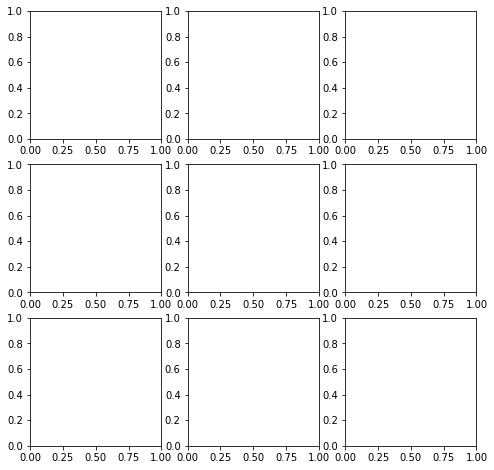

In [105]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))